# 식당 외관 이미지 분류

## 라이브러리 호출

In [1]:
import tensorflow as tf  # 텐서플로 라이브러리
import numpy as np  # 배열 계산 넘파이 라이브러리
import matplotlib.pyplot as plt  # 시각화 라이브러리
import matplotlib.image as img
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation, Dropout, Flatten, Conv2D, MaxPooling2D, BatchNormalization
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import optimizers, metrics  # 모델 훈련
from tensorflow.python.keras.models import load_model
from keras.layers import LeakyReLU
import torch.cuda
import os
import re
import konlpy
from konlpy.tag import *
from selenium import webdriver
from selenium.webdriver.common.by import By
from selenium.webdriver.common.keys import Keys
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.support import expected_conditions as EC
import time
import pandas as pd
from glob import glob
from PIL import Image
import wordcloud as WordCloud
from collections import Counter

# import splitfolders
# splitfolders.ratio('./train2/train',output='./train',seed=580,ratio=(0.8,0.2))

print(torch.cuda.is_available())
print(tf.test.is_built_with_gpu_support())
print(tf.test.gpu_device_name())
print(torch.cuda.get_device_name(torch.cuda.current_device()))

True
True
/device:GPU:0
NVIDIA GeForce RTX 3050 Laptop GPU


# CNN 이미지 분류 알고리즘

In [67]:
np.random.seed(42) # 서로 다른 동일한 셋트리의 고정된 난수 생성
tf.random.set_seed(42) # 위와 동일

train_datagen = ImageDataGenerator(rescale=1./255, # 1/255로 스케일링 하여 0~255 -> 0~1 범위로 변환
                                  horizontal_flip=True, # (True) 1/2 확률로 이미지를 수평으로 뒤집음
                                  width_shift_range=0.1, # 그림을 수평 또는 수직으로 랜덤하게 평행 이동
                                  height_shift_range=0.1, # 위와 동일
                                  fill_mode='nearest') # 이미지를 회전, 이동하거나 축소할 때 생기는 공간을 채움

# 1. IDG가 이미지 파일들을 Numpy Array 형태로 가져온 후 사용자가 설정한 여러가지 증강 기법을 적용할 준비를 함(객체 생성)
# 2. flow_from_directory로 Numpy Array Iterator 객체를 만들어줌. X(image)array, Y(label)array, 배치 사이즈, 데이터 셔플 유무 설정
# 설계한 모델에 fit(_generator)를 호출하면 1,2번 단계가 수행되고 설정된 배치 사이즈 만큼의 Numpy Array 를 Tensor로 바꾸고 본격적인 학습 시작


train_generator = train_datagen.flow_from_directory(
       directory='./train/train',
       target_size=(227, 227), # 사용할 CNN 모델 입력 사이즈에 맞게 resize 
       batch_size=4, # 이미지 데이터 원본 소스에서 한번에 얼만큼의 이미지 데이터를 가져올 것인지
       class_mode='categorical') # 'binary' : 0 or 1 이진 분류 클래스 / 'categorical' : 멀티-레이블 클래스, 원-핫 인코딩된 형테(자연어) / 'sparse' : 멀티-레이블, 레이블 인코딩 된 형태


test_datagen = ImageDataGenerator(rescale=1./255)

test_generator = test_datagen.flow_from_directory(
       directory='./train/val',
       target_size=(227, 227),
       batch_size=4,
       class_mode='categorical')



# x,y = train_generator.next() # train_set의 이미지 데이터 전부

# for i in range(len(x)):  
#     print(x[i].shape)
#     print(y[i])
#     plt.imshow(x[i])
#     plt.show()


# 데이터 라벨 수가 30개 정도로 상당히 부족하기에 과적합을 피하기 위해 드롭아웃을 0.5로 잡음
model = Sequential() # 입력의 데이터 채널 수와 필터의 채널 수가 같아야 함.
model.add(Conv2D(114, (3, 3), input_shape=(227,227,3),strides = 4,activation = 'relu')) # 3차원이므로(입력 데이터 채널 수: 3) 필터는 3개 / RGB는 3차원 흑백은 1차원
# Conv2D는 입/출력 모두 3차원 데이터로 처리 / Conv2D 필터 개수 구하는 식 : ((이미지 size - 커널 size + 2*패딩 size) / strides size ) + 1
model.add(MaxPooling2D(pool_size=(2, 2))) # pooling을 하게 되면 28x28x3의 데이터는 14x14x3로 사이즈는 줄어들지만 개수는 늘어나기에 다음 레이어의 필터 수는 (2x2)만큼 늘려서 처리해야함
BatchNormalization()
model.add(Activation(LeakyReLU(alpha=0.1)))
model.add(Dropout(0.5))

model.add(Conv2D(228, (3, 3),strides = 2 ,activation = 'relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
BatchNormalization()
model.add(Activation(LeakyReLU(alpha=0.1)))
model.add(Dropout(0.5))

model.add(Conv2D(114, (3, 3) ,activation = 'relu'))
BatchNormalization()
model.add(Activation(LeakyReLU(alpha=0.1)))
model.add(Dropout(0.5))



model.add(Flatten()) # 1차원 형태의 배열로 변환
model.add(Dense(57))
BatchNormalization()
model.add(Activation(LeakyReLU(alpha=0.1)))
model.add(Dropout(0.5))
model.add(Dense(5))
model.add(Activation('sigmoid'))


model.summary()


model.compile(loss='MSE', optimizer=optimizers.Adam(learning_rate=0.0005), metrics=['accuracy'])

history = model.fit_generator(
       train_generator,
       steps_per_epoch=len(train_generator),
       epochs=100,
       validation_data=test_generator,
       validation_steps=10)


acc= history.history['accuracy'] 
val_acc= history.history['val_accuracy'] 
y_vloss = history.history['val_loss']

y_loss = history.history['loss']

Found 246 images belonging to 5 classes.
Found 59 images belonging to 5 classes.
Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_30 (Conv2D)          (None, 57, 57, 114)       3192      
                                                                 
 max_pooling2d_20 (MaxPoolin  (None, 28, 28, 114)      0         
 g2D)                                                            
                                                                 
 activation_50 (Activation)  (None, 28, 28, 114)       0         
                                                                 
 dropout_40 (Dropout)        (None, 28, 28, 114)       0         
                                                                 
 conv2d_31 (Conv2D)          (None, 13, 13, 228)       234156    
                                                                 
 max_pooling2d_21 (MaxPoolin  (None, 6

C:\Users\USER\AppData\Local\Temp\ipykernel_3504\857238805.py:77: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(


62/62 [==============================] - 5s 67ms/step - loss: 0.1840 - accuracy: 0.1992 - val_loss: 0.1638 - val_accuracy: 0.2500
Epoch 2/100
62/62 [==============================] - 5s 73ms/step - loss: 0.1712 - accuracy: 0.2602 - val_loss: 0.1647 - val_accuracy: 0.2750
Epoch 3/100
62/62 [==============================] - 4s 56ms/step - loss: 0.1669 - accuracy: 0.2317 - val_loss: 0.1621 - val_accuracy: 0.3000
Epoch 4/100
62/62 [==============================] - 4s 59ms/step - loss: 0.1642 - accuracy: 0.2927 - val_loss: 0.1594 - val_accuracy: 0.3750
Epoch 5/100
62/62 [==============================] - 4s 70ms/step - loss: 0.1629 - accuracy: 0.2561 - val_loss: 0.1471 - val_accuracy: 0.4500
Epoch 6/100
62/62 [==============================] - 4s 60ms/step - loss: 0.1636 - accuracy: 0.3333 - val_loss: 0.1412 - val_accuracy: 0.4750
Epoch 7/100
62/62 [==============================] - 4s 66ms/step - loss: 0.1499 - accuracy: 0.3862 - val_loss: 0.1326 - val_accuracy: 0.5000
Epoch 8/100
62/62 

### TrainSet - accuarcy/loss 시각화

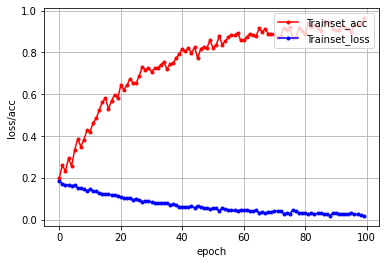

In [71]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
y_vloss = history.history['val_loss']
y_loss = history.history['loss']
x_len = np.arange(len(y_loss))

a = plt.plot(x_len, acc, marker='.', c="red", label='Trainset_acc')
d = plt.plot(x_len, y_loss, marker='.', c="blue", label='Trainset_loss')

plt.legend(loc='upper right')
plt.grid()
plt.xlabel('epoch')
plt.ylabel('loss/acc')
plt.show()


### Validation - accuracy/loss 시각화

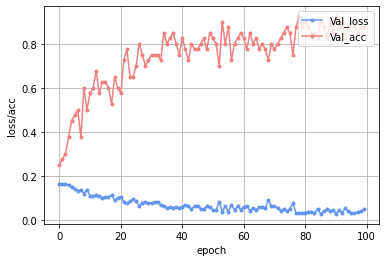

In [72]:
c = plt.plot(x_len, y_vloss, marker='.',
             c="cornflowerblue", label='Val_loss')
b = plt.plot(x_len, val_acc, marker='.', c="lightcoral", label='Val_acc')

plt.legend(loc='upper right')
plt.grid()
plt.xlabel('epoch')
plt.ylabel('loss/acc')
plt.show()


## 라벨링한 식당명을 결과로 추출할 함수
(직접 작성했지만 추후 라벨링 폴더명으로 추출할 코드 작성하려고 함)

In [2]:
# 기존 라벨  = {0:"ant", 1:"han", 2:"bro", 3:"gaya", 4:"kindess"}

def convert_name(name):
    if name==None :
        return np.nan
    
    if name==0:
        return '개미집'
    
    elif name==1:
        return '바보형제쭈꾸미'
    
    elif name== 2:
        return '가야포차'
    
    elif name ==3:
        return '한신포차'
    
    else :
        return '착한까스'


# 결과 출력 함수

In [3]:
def classification_restaurants(model,filepath):  
    test_imgs_dir=os.listdir(filepath)

    for i in test_imgs_dir:
            img=tf.io.read_file(filepath+"/"+i)
            img=tf.image.decode_jpeg(img,channels=3) # R,G,B 3개의 채널을 가진 이미지 처리
            img=tf.image.convert_image_dtype(img,float) # 정규화(Normalization 0-255 -> 1)
            img=tf.image.resize(img,[227,227])# Resize / 기존 : 120 x 120 
    
            plt.imshow(img)
            plt.show()
        
            img=tf.expand_dims(img,0) #차원추가 
            alpha=model.predict(img)
    
        
            arg=convert_name(np.argmax(alpha[0]))
        
            print('The predict is ', arg)
            print(f"{arg}일확률: {alpha[0][np.argmax(alpha[0])]*100:.3f}%")
            
            return arg

In [4]:
# 파일 내에 있는 모든 함수 호출
from Token_WordCloud import *
from Insta_Crawl import extract_insta_data

### 파일 경로 설정

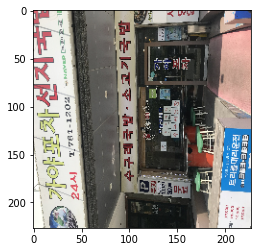

The predict is  가야포차
가야포차일확률: 86.999%


In [5]:
model = load_model('./cnn_save_model/new_88%_cnn_model.h5')

login_option = "instagram" # instagram or facebook
user_id = "alsgh0717@naver.com" # 인스타그램 아이디
user_passwd = "France1789!" # 인스타그램 비밀번호
wish_num = 3 # 원하는 게시물의 개수
filepath = "C:/Users/USER/Desktop/Ant/restaurant/test/test" # test 이미지 파일이 있는 폴더 경로
keyword = classification_restaurants(model, filepath) # 파일 내에 있는 이미지를 분류하여 키워드를 반환함
driver_path = "C:/Users/USER/Desktop/Ant/restaurant/chromedriver.exe" # 크롬 드라이버 경로
save_path = "C:/Users/USER/Desktop/Ant/restaurant/save_file" # 저장할 폴더 경로
cloud_shape_path = "C:/Users/USER/Desktop/Ant/restaurant/word_cloud_shape.png" # 클라우드 이미지 모양 경로
font_path = "C:/Users/USER/Desktop/Ant/restaurant/NanumSquareRoundR.ttf" # 폰트 경로


# 최종 결과 출력

작성자: minn_chelin	 게시일: 2020년 9월 10일


연산동 가야포차수구레국밥
혼밥
첨 먹어본 수구레 국밥
국물은 해운대에서 자주 먹었던 소고기국밥이랑 비슷하구나
계란말이까지
해장 아이템으로 굿뜨



부산
부산맛집
연산동
부산국밥
부산선지국밥맛집
부산연산동맛집
먹스타그램
술스타그램
먹방
맛집
먹스타
일상
존맛
저녁
푸드스타그램
먹방스타그램
맛스타
맛있다그램
인스타푸드
럽스타그램
맞팔
홍대맛집
동래맛집
서면맛집
선지국밥
민슐랭_연산동
가야포차
수구레국밥
연산동맛집

게시글로 이동 : https://www.instagram.com/p/CE8AMuGFTeI/





작성자: scelomania	 게시일: 2021년 11월 24일

언제나 국밥에 진심인 사람으로써 요즘처럼 국물이 간절한 때가 없다며 내의에 경량 패딩 장착 마스크땜에 올해 한번도 안걸린 감기가 걸릴 것 같은

그러고 보니 5년 전엔가 장례식 가서 한글로 된 부의금 봉투를 쓸 일이 있었는데 부의금 받는 분들이 쑤근쑤근하고 심지어 옆에 어르신은 못배운 티 낸다고 한 소리 하시더라고

조선 세종 때 한글 반포할 때 대충 어떤 분위기였을지 알 것 같은 순간 이었음

소고기국밥 때문일까요 이런 흐름은
아 발목이야 침맞아야겠다
아무말대잔치

가야포차 수구레국밥
가야포차수구레국밥

게시글로 이동 : https://www.instagram.com/p/CWoz5SXhBzj/





작성자: lee_jg88	 게시일: 2022년 8월 21일

오늘도 부산
부산은  자주 와도와도
그립다
그냥 뭔가가 그립다
동네맛집 느낌으로 한잔했다
너무 좋더라 
닭발지존가야포차닭발맛집조개탕진짜맛집부산맛집닭발맛집수구레국밥부산핫플레이스찐맛집수영구맛집서면맛집전포동

게시글로 이동

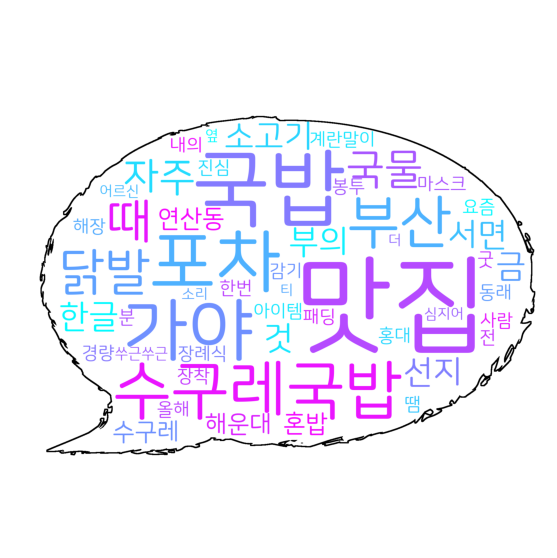

In [6]:
#extract_insta_data(login_option,user_id,user_passwd,wish_num,keyword,driver_path,save_path) : # 추출
#로그인 수단 /id / pw /게시글 갯수 / keyword (사용할 모델 / 예측할 image file path)  / 크롬 드라이버 경로 / csv 저장경로
# extract_insta_data(login_option, user_id, user_passwd, wish_num,
#                    keyword, driver_path, save_path)

df = pd.read_csv(save_path+"/"+"instagram_extract.csv")  # 크롤링한 text road
# main text 전처리   (특수문자, 이모티콘 ,모음과 자음만 있는 text 삭제)
preprocessed_main_text_list = get_clean_text(df)

df['main_text'] = preprocessed_main_text_list  # 전처리된 text로 바꿈
df["date_title"] = df["date_title"].apply(convert_date)  # 날자 포맷수정

if df.isnull().sum().sum() > 0:  # 데이터에 결측 값이 있다면
    df.dropna(inplace=True)  # nan값처리 (axis=0, how='any')
    df = df.reset_index(drop=True)
    print("\n\n")  # 인덱스 당기기
    
for i in range(len(df)):
    if count_string(df["main_text"][i]) >= 10:  # 게시글이 공백(enter)을 제외하고 N자 이상
        print(f'작성자: {df["upload_id"][i]}\t 게시일: {df["date_title"][i]}\
\n\n{df["main_text"][i]}\n\n게시글로 이동 : {df["location_href"][i]}\n\n\n\n\n')
        
word_cloud(df,cloud_shape_path,font_path)